# Project Introduction

List different versions of the dataset and the order of the process

8 main sections

1. Data Cleaning
2. Exploratory Data Analysis (EDA)
3. Data Transforms
4. Feature Selection
5. Model Development
6. Hyperparameter Tuning
7. Ensemble Modeling
8. Neural Network Modeling


# Import Modules and Data

We will use a fairly standard set of machine learning libraries in our analysis including:

* numpy
* pandas
* matplotlib
* seaborn
* sklearn

In [25]:
import os
from warnings import filterwarnings
from pickle import dump, load
filterwarnings('ignore', message='numpy.dtype size changed')
filterwarnings('ignore', message='Using a non-tuple sequence for multidimensional indexing is deprecated')
filterwarnings('ignore', message='numpy.core.umath_tests is an internal NumPy module and should not be imported')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

Next we load the raw data downloaded from Kaggle

In [5]:
os.chdir('../data/')
raw = pd.read_csv('kickstarter.csv', parse_dates=[5, 7])
raw.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

# Data Cleaning

To begin, let's familiarize ourselves with the dataset

In [65]:
raw.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


 First, we notice that there are two columns for the amount of money pledged: `usd pledged` and `usd_pledged_real`. According to documentation for the dataset, the former was converted by Kickstarter and the later by the fixer.io API. Looking at rows 1, 41, 43, and others we can see that the amount in `pledged` does not match `usd pledged` even though the currency for the project is USD. Therefore, `usd_pledged_real` is the more reliable column to use.

We will also drop the project ID since that is a random number which should have no correlation to the project's success. Lastly, the `goal` column is reported in original currency. Since we are converting all amounts to USD for consistency, this is not necessary.

In [66]:
clean = raw.drop(columns=['usd pledged', 'ID', 'goal'])
clean.rename(columns={'usd_pledged_real':'pledged_usd', 'usd_goal_real':'goal_usd'}, inplace=True)

Next, let's look at our target variable `state` and see how it is distributed. The majority of projects are either failed of successful. Canceled is the next biggest category.

In [67]:
clean.groupby('state').size().sort_values(ascending=False)

state
failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
dtype: int64

We can simplify this to a binary classification problem with failed or canceled as 0 and successful as 1. Additionally, since we are trying to predict a project's `state` when it launches, any information from the future should be removed.

In [68]:
clean = clean[clean.state.isin(['successful', 'failed', 'canceled'])]
clean.state = clean.state.replace({'successful':1, 'failed':0, 'canceled':0})
clean.drop(columns=['pledged', 'backers', 'pledged_usd'], inplace=True)

It would be interesting to know the duration of each project. First, `launched` needs to be split into its day and time components, and then we can subtract the day component from `deadline`. While we're manipulating `launched`, let's also turn `launch_time` into a numeric format (decimal hours on a 24 hour clock). Checking our work with a quick histogram of `duration`, it is suspicious that there are projects that lasted longer than 14,000 days (over 38 years)!

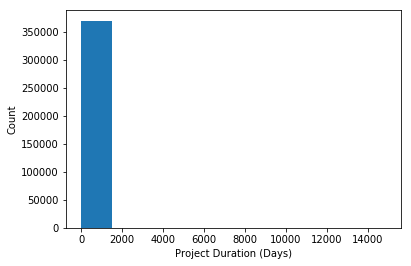

In [69]:
clean['launch_day'] = [d.date() for d in clean.launched]
clean['launch_time'] = [d.time() for d in clean.launched]
clean[['h', 'm', 's']] = clean.launch_time.astype(str).str.split(':', expand=True).astype(float)
clean['launch_time'] = clean.h.values + clean.m.values / 60 + clean.s.values / 3600
clean.drop(columns=['h', 'm', 's'], inplace=True)
clean['duration'] = [(d - l).days for d, l in zip(clean.deadline.dt.date, clean.launch_day)]
clean.drop(columns='launched', inplace=True)

fig = plt.figure()
plt.hist(clean.duration)
plt.xlabel('Project Duration (Days)')
plt.ylabel('Count')
plt.show()

Looking at the year from `launch_time`, there are some projects which supposedly started in 1970. However, Kickstarter didn't even exist back then so these are most likely data entry errors and we will remove them. Making a `launch_year` category and then querying the dataframe is an easy way to accomplish this. When the histogram for duration is re-plotted, it looks much more reasonable.

[1970 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


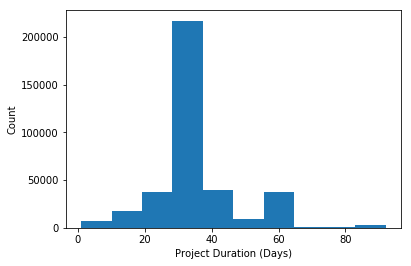

In [70]:
print(np.unique([d.year for d in clean.launch_day]))
clean['launch_year'] = [d.year for d in clean.launch_day]
clean.query('launch_year != 1970', inplace=True)

fig = plt.figure()
plt.hist(clean.duration)
plt.xlabel('Project Duration (Days)')
plt.ylabel('Count')
plt.show()

To make separating our target variable (`state`) from the features, we will move it to the last column. Then the cleaned data is written to a CSV so we don't need to repeat these steps in the future.

In [71]:
cols = list(clean.columns)
cols.append(cols.pop(cols.index('state')))
clean = clean.reindex(columns=cols)
clean.to_csv('kickstarter-clean.csv', index=False)

# Exploratory Data Analysis (EDA)

Let's start by seeing how projects are distributed by category. If you're just starting the notebook from this section, you'll want to read in `kickstarter-clean.csv` (the CSV we saved after data cleaning).

In [73]:
clean = pd.read_csv('kickstarter-clean.csv', parse_dates=[4, 7])

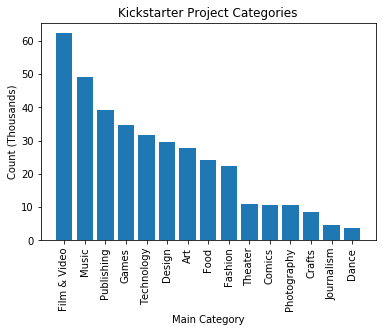

In [205]:
main_categories = clean.groupby('main_category').size().sort_values(ascending=False)
n_main = [i / 1000 for i in list(main_categories)]
labels_main = list(main_categories.index)

ind = np.arange(len(main_categories))
plt.bar(ind, n_main)
plt.ylabel('Count (Thousands)')
plt.xlabel('Main Category')
plt.title('Kickstarter Project Categories')
plt.xticks(ind, labels_main, rotation=90)
plt.show()

How does sucess vary with factors like duration, goal, and time of day the project was launched?

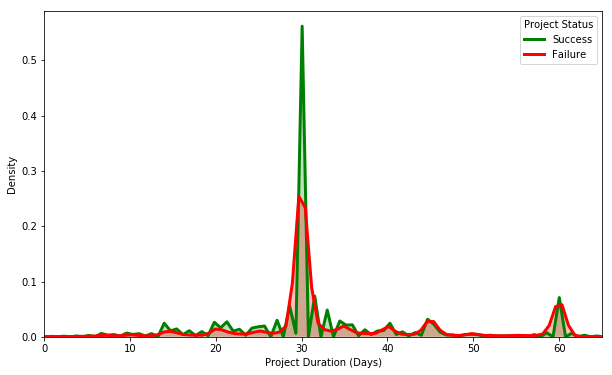

In [206]:
plt.figure(figsize=(10, 6))
sns.distplot(clean.query('state == 1').duration, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, 
             label='Success', color='green')
sns.distplot(clean.query('state == 0').duration, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, 
             label='Failure', color='red') 
plt.legend(title='Project Status')
plt.xlabel('Project Duration (Days)')
plt.ylabel('Density')
plt.xlim((0, 65))
plt.show()

The vast majority of projects are 30 days long regardless of their status. The next largest peaks are at 60 and 45 days, indicating that projects tend to be scheduled in terms of months (1, 1.5, 2, etc). There is a slight trend
towards shorter durations leading to an increased chance of success (more 15-25 day project succeeded).

Now we can look at the project funding goal (converted to USD for a fair comparison across all the currencies). Plotting on a log10 scale helps compress the data into a viewable range since goals range from \$0.01 up to over \$166,000,000

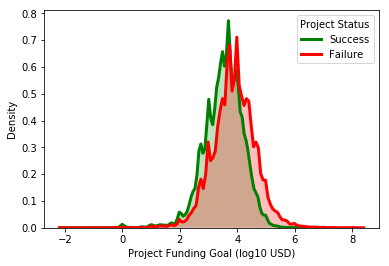

In [207]:
sns.distplot(np.log10(clean.query('state == 1').goal_usd.values), hist=False, kde=True, 
             kde_kws={'shade': True, 'linewidth': 3}, label='Success', color='green')
sns.distplot(np.log10(clean.query('state == 0').goal_usd.values), hist=False, kde=True, 
             kde_kws={'shade': True, 'linewidth': 3}, label='Failure', color='red') 
plt.legend(title='Project Status')
plt.xlabel('Project Funding Goal (log10 USD)')
plt.ylabel('Density')
plt.show()

The distinction between failure and sucess is a more pronounced here than for duration - projects with a larger funding goal failed more often. The most common goals were around \$10k USD.

What about time of day the project was launched? If people are most likely to hear about a project at its inception, it would be critical to launch at a time when people are available (for instance, weekday evenings).

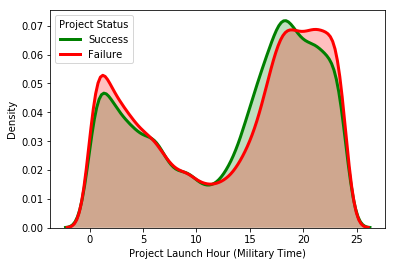

In [208]:
sns.distplot(clean.query('state == 1').launch_time, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, 
             label='Success', color='green')
sns.distplot(clean.query('state == 0').launch_time, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, 
             label='Failure', color='red') 
plt.legend(title='Project Status')
plt.xlabel('Project Launch Hour (Military Time)')
plt.ylabel('Density')
plt.show()

Failed projects look like they may launch more often at the extreme start/end of days, but the trend is not super strong. Another angle to explore the data from in the future is using Natural Language Processing (NLP). We could see whether there are words or phrases in the project names that correspond well with the project's success.

# Data Transforms

For modeling purposes, we will need a numeric representation of all the columns containing datetimes (`deadline`, `launch_day`, and `launch_time`) and categorical strings (`name`, `category`, `main_category`, `currency`, and `country`). Let's start with representing the datetime columns numerically. 

As we learned above, there are few projects lasting longer than 60 days, so the year information in `deadline` and `launch_day` should be similar. The remaining month and day information can be encoded as day of year (i.e. 1 to 365). Adding a cosine transform is useful here since it indicates to the model that days 1 and 365 are actually more similar than days 1 and 300. Similarly, we can convert `launch_time` into a decimal hour representation on a 24 hour clock and apply another cosine transform.

In [6]:
clean = pd.read_csv('kickstarter-clean.csv', parse_dates=[4, 7])
transformed = clean
transformed.launch_day = [np.cos(d.timetuple().tm_yday / 365 * 2 * np.pi) for d in clean.launch_day] 
transformed.deadline = [np.cos(d.timetuple().tm_yday / 365 * 2 * np.pi) for d in clean.deadline]
transformed.launch_time = np.cos(clean.launch_time.astype('float') / 24 * 2 * np.pi)

Next we'll deal with the categorical string columns. Since all monetary amounts have already been converted to USD, there is no need for the `currency` column in modeling. Until we do further NLP research, the best way to encode the project name will be its length. The remaining categorical variables can be one-hot encoded using the `get_dummies()` function from pandas. After performing the transforms, we print the column `dtypes` to double check that all variables are numerical now.

In [7]:
transformed.drop(columns='currency', inplace=True)
transformed.name = clean.name.str.len()
transformed.dropna(inplace=True) # Some strings returned NA
transformed = pd.get_dummies(transformed)
transformed.dtypes

name                         float64
deadline                     float64
goal_usd                     float64
launch_day                   float64
launch_time                  float64
duration                       int64
launch_year                    int64
state                          int64
category_3D Printing           uint8
category_Academic              uint8
category_Accessories           uint8
category_Action                uint8
category_Animals               uint8
category_Animation             uint8
category_Anthologies           uint8
category_Apparel               uint8
category_Apps                  uint8
category_Architecture          uint8
category_Art                   uint8
category_Art Books             uint8
category_Audio                 uint8
category_Bacon                 uint8
category_Blues                 uint8
category_Calendars             uint8
category_Camera Equipment      uint8
category_Candles               uint8
category_Ceramics              uint8
c

Now that all variables are numerical, we can check for any pairs that are highly correlated (i.e. $R > 0.8$) since those will adversely affect modeling. Unsurprisingly, `launch_day` and `deadline` are highly correlated. Let's keep `launch_day` over `deadline` since it's more closely related to the start of a project. There are also a few `category` / `main_category` combinations which appear to contain duplicate information - for instance theater and design. We'll keep the `main_category` version of each of those since that should apply to more rows of the dataframe. Note this does not mean we are removing theater or design projects from the data, but rather not giving our model access to that label information.

In [8]:
print(transformed.corr().unstack().sort_values().drop_duplicates())
transformed.drop(columns=['deadline', 'category_Theater', 'category_Product Design'], inplace=True)

country_US                  country_GB                   -0.594273
country_CA                  country_US                   -0.382302
launch_year                 country_US                   -0.298651
country_AU                  country_US                   -0.275541
country_DE                  country_US                   -0.199260
main_category_Music         main_category_Film & Video   -0.176040
duration                    launch_year                  -0.169981
country_FR                  country_US                   -0.167412
country_NL                  country_US                   -0.165463
country_US                  country_IT                   -0.164510
main_category_Film & Video  launch_year                  -0.162609
main_category_Publishing    main_category_Film & Video   -0.154311
country_ES                  country_US                   -0.146497
main_category_Film & Video  main_category_Games          -0.144574
main_category_Music         launch_year                  -0.14

# Feature Selection

Since all our cleaning and data pre-processing was saved out to `kickstarter-transformed.csv`, we'll read that in first. Then, the pandas dataframe needs to be converted to numpy arrarys `x` and `y` to work with the modeling functions in sklearn. These are then split into 80% training and 20% testing. We'll run our intial models on the training data *only* and save the test set as a final validation.

In [6]:
seed = 1234
y = transformed.state.values
x = transformed.values[:, :-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
print(x.shape)

(370445, 201)


There are just over 200 features in our dataset! Chances are not all of them will be useful for predicting a project's chance of success, so we'll the `sklearn.feature_selection` module to tease out which features show the most promise. To start, let's look at feature importance values from a Random Forest model.

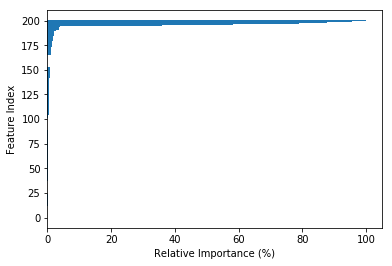

In [8]:
selector = RandomForestClassifier()
selector.fit(x_train, y_train)
importance = selector.feature_importances_
importance_relative = importance / max(importance) * 100
indices = np.argsort(importance_relative)

plt.barh(range(len(indices)), importance_relative[indices], align='center')
plt.xlabel('Relative Importance (%)')
plt.ylabel('Feature Index')
plt.show()

As expected, there are about 10 to 25 features which have substantially more importance than the rest. Let's re-plot with only the top 10 and add y-axis labels to see what those are.

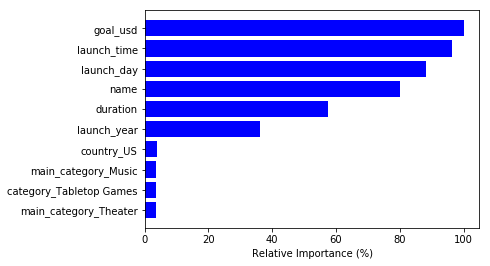

In [12]:
features = transformed.columns
top = 10

plt.barh(range(len(indices[-top:])), importance_relative[indices[-top:]], align='center')
plt.xlabel('Relative Importance (%)')
plt.yticks(range(len(indices[-top:])), [features[i] for i in indices[-top:]])
plt.show()

The results from this look quite definitive and agrees with our observations during EDA about `goal_usd`. Going forward we will retain the top 6 variables. Now we are ready to start testing different models.

In [9]:
x = x[:, indices[-6:]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
print(x.shape)

(370445, 6)


# Model Development

As a baseline to compare our other models to, let's consider what accuracy a classifier could achieve if it always predicted the majority class.

In [28]:
classes = transformed.groupby('state').size().sort_values(ascending=True) 
classes[0] / sum(classes)

0.638391664079688

Due to the slight class imbalance, we can expect 63.8% accuracy just by predicting `state = 0` (failed) every time. Let's compare this benchmark to several different machine learning algorithms. These will include 2 linear algorithms (Logistic Regression and Linear Discriminant Analysis) and 3 non-linear algorithms (K Nearest Neighbors, Decision Trees, and Naive Bayes). 10-fold cross validation provides a good estimate of model performance on new data. To ensure the results are reproducible, we'll use the seed we set manually above.

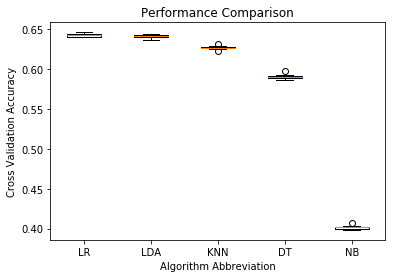

In [29]:
models = [('LR', LogisticRegression()), ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()), ('DT', DecisionTreeClassifier()), ('NB', GaussianNB())]
names = [n for n, m in models]
ctrl = KFold(n_splits=10, random_state=seed)
results = [cross_val_score(m, x_train, y_train, cv=ctrl) for n, m in models]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.title('Performance Comparison')
plt.xlabel('Algorithm Abbreviation')
plt.ylabel('Cross Validation Accuracy')
ax.set_xticklabels(names)
plt.show()

Before making any final decisions, let's try adding a scaling pre-processing step to the data and see how it affects performance. To implement this in sklearn, we'll need to define a pipeline for each model.

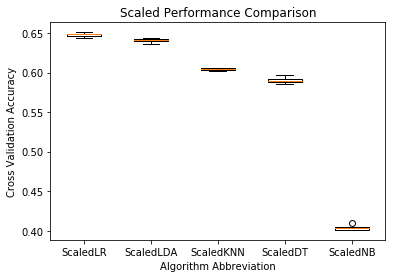

In [30]:
pipelines = [('ScaledLR',  Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])), 
             ('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])), 
             ('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])), 
             ('ScaledDT',  Pipeline([('Scaler', StandardScaler()), ('DT', DecisionTreeClassifier())])),
             ('ScaledNB',  Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())]))]

names = [n for n, p in pipelines]
ctrl = KFold(n_splits=10, random_state=seed)
results = [cross_val_score(p, x_train, y_train, cv=ctrl) for n, p in pipelines]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.title('Scaled Performance Comparison')
plt.xlabel('Algorithm Abbreviation')
plt.ylabel('Cross Validation Accuracy')
ax.set_xticklabels(names)
plt.show()

Unfortunately even after scaling the data, none of the candidate algorithms are performing significantly better than our benchmark. This may indicate the need for a more complex model, so we'll try a couple different ensemble methods next to see if there is any improvement. If those don't show any promise, we can always come back to the above algorithms and see if we can boost their performance either by optimizing hyperparameters or using some form of regularization.

# Ensemble Modeling

We'll start with the default parameters of 3 different ensemble methods: Random Forest, AdaBoost, and Gradient Boosting Machines. Scaling looks like it hurt the performance of our other algorithms, so we'll start training the ensembles on the unscaled data.

In [36]:
ensembles = [('RF', RandomForestClassifier()), 
             ('Ada', AdaBoostClassifier()), 
             ('Grad', GradientBoostingClassifier())]
names = [n for n, e in ensembles]
results = [cross_val_score(e, x_train, y_train, cv=ctrl) for n, e in ensembles]

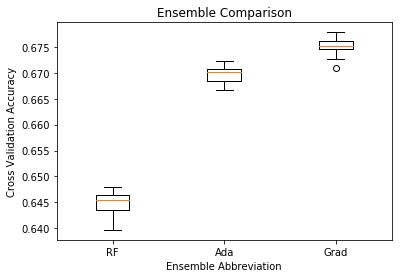

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.title('Ensemble Comparison')
plt.xlabel('Ensemble Abbreviation')
plt.ylabel('Cross Validation Accuracy')
ax.set_xticklabels(names)
plt.show()

In [39]:
print('Gradient Boosting accuracy: {:.4f}%'.format(results[2].mean() * 100))

Avg. Gradient Boosting accuracy: 67.5077%


This is nothing fantastic, but it's also the first time we've seen an algorithm consistently perform better than our benchmark! Let's check whether scaling would help Gradient Boosting learn better.

In [44]:
grad_scaled = Pipeline([('Scaler', StandardScaler()), ('Grad', GradientBoostingClassifier())])
results = cross_val_score(grad_scaled, x_train, y_train, cv=ctrl)
print('Scaled Gradient Boosting accuracy: {:.4f}%'.format(results.mean() * 100))

Scaled Gradient Boosting accuracy: 67.4935%


# Hyperparameter Tuning

Scaling the input features did not help Gradient Boosting, so let's see if we can optimize some of the algorithm's hyperparameters instead. Some options we may want to consider are:

* `n_estimators`: number of boosting iterations to perform
* `max_depth`: number of splits each individual estimator tree is allowed to have.
* `learning_rate`: controls the contribution of each individual estimator tree
* `max_features`: fraction of features to consider when deciding a split
* `subsample`: fraction of samples used to fit each individual estimator tree

To start, we'll look at `n_estimators` since it might be the case that our ensemble didn't have enough iterations to learn. From there we can further optimize the other parameters.

In [10]:
param_grid = dict(n_estimators = np.arange(50, 500, 50))
ctrl = KFold(n_splits=3, random_state=seed)
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=ctrl)
estimators_result = grid.fit(x_train, y_train)

Since the grid search takes so long to run, we'll quickly save a pickled version of the results in case we need to access them again later.

In [29]:
dump(estimators_result, open('kickstarter-n_estimators.pkl', 'wb'))

When plotting accuracy as a function of `n_estimators`, there is a clear trend. However, the minor gain in performance is definitely not worth the increased computational cost.

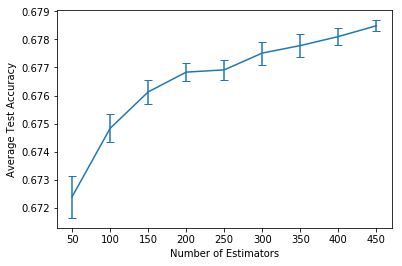

In [46]:
plt.errorbar(x=np.arange(50, 500, 50), 
             y=estimators_result.cv_results_['mean_test_score'], 
             yerr=estimators_result.cv_results_['std_test_score'], 
             capsize=4)
plt.xlabel('Number of Estimators')
plt.ylabel('Average Test Accuracy')
plt.show()

In [48]:
grid = GridSearchCV(GradientBoostingClassifier(), dict(max_depth=np.arange(1, 10, 1)), cv=ctrl)
depth_result = grid.fit(x_train, y_train)

In [50]:
dump(depth_result, open('kickstarter-max_depth.pkl', 'wb'))

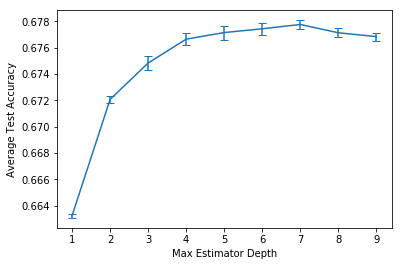

In [49]:
plt.errorbar(x=np.arange(1, 10, 1), 
             y=depth_result.cv_results_['mean_test_score'], 
             yerr=depth_result.cv_results_['std_test_score'], 
             capsize=4)
plt.xlabel('Max Estimator Depth')
plt.ylabel('Average Test Accuracy')
plt.show()

# Neural Network Modeling

In [42]:
?GradientBoostingClassifier